## Pothole Detection using RCNN Round 2 of training

We will continue to train FasterRCNN model using torchvision on the Pothole Dataset with COCO JSON annotations.

First we will load the previously trained model and then train for 100 epochs with learning rate = 0.001 with a patience of 5 epochs against validation mean Average Precision (mAP)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip show torchvision

Name: torchvision
Version: 0.20.1+cu124
Summary: image and video datasets and models for torch deep learning
Home-page: https://github.com/pytorch/vision
Author: PyTorch Core Team
Author-email: soumith@pytorch.org
License: BSD
Location: /usr/local/lib/python3.11/dist-packages
Requires: numpy, pillow, torch
Required-by: fastai, timm


In [ ]:
!pip install bbox-utils

In [ ]:
import os
import cv2
import torch
import numpy as np
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils
from collections import defaultdict
from tqdm import tqdm

In [ ]:
import matplotlib.pyplot as plt
import copy
from pycocotools.cocoeval import COCOeval
import json

In [ ]:
from bbox_utils.bbox_2d import BoundingBox

In [ ]:
# Set device (GPU if available, else CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Define paths
data_dir = "/content/drive/My Drive/Omdena_Pothole/Yolo_Coco_Images"

# Prepare datasets
train_root = os.path.join(data_dir, "train/images")
val_root = os.path.join(data_dir, "valid/images")
test_root = os.path.join(data_dir, "test/images")

train_annFile = os.path.join(train_root, "train_annotations.coco.json")
val_annFile = os.path.join(val_root, "valid_annotations.coco.json")
test_annFile = os.path.join(test_root, "test_annotations.coco.json")

# Hyperparameters
num_classes = 5  # 4 pothole classes + 1 background class
batch_size = 4
num_epochs = 100
learning_rate = 0.001
momentum = 0.9
weight_decay = 0.0005
step_size = 3
gamma = 0.1
patience = 5

BEST_MODEL_PATH_OLD = "/content/drive/My Drive/Omdena_Pothole/Models/pothole_rcnn_best_round1.pth"
BEST_MODEL_PATH = "/content/drive/My Drive/Omdena_Pothole/Models/pothole_rcnn_best.pth"

In [ ]:
# Load COCO annotations
coco_train = COCO(os.path.join(train_root, train_annFile))
coco_val = COCO(os.path.join(val_root, val_annFile))
coco_test = COCO(os.path.join(test_root, test_annFile))

# Custom Dataset Class
class PotholeDataset(Dataset):
    def __init__(self, root, coco, transforms=None):
        self.root = root
        self.coco = coco
        self.transforms = transforms
        self.ids = list(sorted(coco.imgs.keys()))

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.root, img_info['file_name'])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        boxes = []
        labels = []
        for ann in anns:
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])
            labels.append(ann['category_id'])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(anns),), dtype=torch.int64)
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }
        if self.transforms:
            img = self.transforms(img)
        return img, target

    def __len__(self):
        return len(self.ids)

# Data Transforms
def get_transform(train):
    transforms = []
    transforms.append(torchvision.transforms.ToTensor())
    if train:
        transforms.append(torchvision.transforms.RandomHorizontalFlip(0.5))
    return torchvision.transforms.Compose(transforms)

# Create datasets and dataloaders
train_dataset = PotholeDataset(train_root, coco_train, get_transform(train=True))
val_dataset = PotholeDataset(val_root, coco_val, get_transform(train=False))
test_dataset = PotholeDataset(test_root, coco_test, get_transform(train=False))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

loading annotations into memory...
Done (t=4.71s)
creating index...
index created!
loading annotations into memory...
Done (t=1.97s)
creating index...
index created!
loading annotations into memory...
Done (t=1.49s)
creating index...
index created!


## Helper methods

In [ ]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10):
    model.train()
    total_loss = 0

    for i, (images, targets) in enumerate(tqdm(data_loader, desc=f"Epoch {epoch}")):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()

        if (i + 1) % print_freq == 0:
            print(f"  Batch {i + 1}/{len(data_loader)}: Loss: {losses.item():.4f}")

    avg_loss = total_loss / len(data_loader)
    print(f"Epoch {epoch} - Average Loss: {avg_loss:.4f}")
    return avg_loss



In [ ]:
def evaluate(model, data_loader, device):
    model.eval()
    coco_results = []
    coco_img_ids = []

    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Evaluating"):
            images = list(img.to(device) for img in images)

            outputs = model(images)

            for i, output in enumerate(outputs):
                # Get the correct image_id from the target
                image_id = targets[i]["image_id"].item()

                # Get the original image id from the dataset using the index
                original_image_id = data_loader.dataset.ids[image_id]

                coco_img_ids.append(original_image_id)  # Append original image ID

                if len(output["boxes"]) == 0:
                    continue

                boxes = output["boxes"].cpu().numpy()
                scores = output["scores"].cpu().numpy()
                labels = output["labels"].cpu().numpy()

                for box, score, label in zip(boxes, scores, labels):
                    xmin, ymin, xmax, ymax = box
                    # Convert to COCO format [x, y, width, height]
                    coco_box = [float(xmin), float(ymin), float(xmax - xmin), float(ymax - ymin)]

                    # Map back from consecutive indices to original category IDs
                    # Check if label is within bounds of category IDs
                    try:
                        original_cat_id = data_loader.dataset.coco.getCatIds()[label - 1]  # Subtracting 1 since labels start from 1 in some COCO datasets while getCatIds starts from 0
                    except IndexError:
                        print(f"Warning: Label {label} out of range for category IDs. Skipping this detection.")
                        continue  # Skip this detection

                    result = {
                        "image_id": original_image_id,  # Use original image ID
                        "category_id": original_cat_id,
                        "bbox": coco_box,
                        "score": float(score)
                    }
                    coco_results.append(result)

    # Create COCO evaluation object and calculate metrics if results are available
    if coco_results:
        coco_gt = data_loader.dataset.coco  # Get the ground truth COCO object
        coco_dt = coco_gt.loadRes(coco_results)  # Load the results as a COCO object

        coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
        coco_eval.params.imgIds = coco_img_ids  # Set the image IDs for evaluation
        coco_eval.evaluate()
        coco_eval.accumulate()
        coco_eval.summarize()

        # Return the mean Average Precision (mAP)
        return coco_eval.stats[0]  # mAP @ IoU=0.5:0.95
    else:
        print("Warning: No detections found. Returning 0 for mAP.")
        return 0.0  # Return 0 if no detections were made

In [ ]:
def save_model(model, filename):
    torch.save(model.state_dict(), filename)
    print(f"Model saved to {filename}")

In [ ]:
def visualize_predictions(model, dataset, device, num_images=5, confidence_threshold=0.5):
    """
    Visualize model predictions on random images from the dataset
    """
    model.eval()
    plt.figure(figsize=(15, num_images * 5))

    for i in range(num_images):
        # Get random image
        idx = np.random.randint(0, len(dataset))
        img, target = dataset[idx]

        # Get prediction
        with torch.no_grad():
            prediction = model([img.to(device)])[0]

        # Convert image for display
        img = img.permute(1, 2, 0).cpu().numpy()

        # Plot original image with ground truth
        plt.subplot(num_images, 2, 2*i + 1)
        plt.imshow(img)
        plt.title("Ground Truth")

        # Draw ground truth boxes
        for box, label in zip(target['boxes'], target['labels']):
            x1, y1, x2, y2 = box
            plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                             fill=False, color='green', linewidth=2))

            # Check if label is within bounds of category IDs
            category_ids = dataset.coco.getCatIds()
            label_item = label.item()
            if 0 <= label_item - 1 < len(category_ids):  # Subtract 1 to adjust for 0-based indexing if necessary
                category_name = dataset.coco.cats[category_ids[label_item - 1]]['name']  # Use label_item - 1
                plt.text(x1, y1, f"Class: {category_name}", color='white', backgroundcolor='green')
            else:
                print(f"Warning: Label {label_item} out of range for category IDs. Skipping this detection.")

        # Plot image with predictions
        plt.subplot(num_images, 2, 2*i + 2)
        plt.imshow(img)
        plt.title("Predictions")

        # Filter predictions by confidence threshold
        keep = prediction['scores'] > confidence_threshold
        boxes = prediction['boxes'][keep].cpu().numpy()
        labels = prediction['labels'][keep].cpu().numpy()
        scores = prediction['scores'][keep].cpu().numpy()

        # Draw predicted boxes
        for box, label, score in zip(boxes, labels, scores):
            x1, y1, x2, y2 = box
            plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                             fill=False, color='red', linewidth=2))
            # Check if label is within bounds of category IDs
            category_ids = dataset.coco.getCatIds()
            if 0 <= label - 1 < len(category_ids):  # Subtract 1 to adjust for 0-based indexing if necessary
                category_name = dataset.coco.cats[category_ids[label - 1]]['name']  # Use label - 1
                plt.text(x1, y1, f"Class: {category_name}, {score:.2f}", color='white', backgroundcolor='red')
            else:
                print(f"Warning: Label {label} out of range for category IDs. Skipping this detection.")

    plt.tight_layout()
    plt.savefig('test_predictions.png')
    plt.show()

## Load model and start training

In [ ]:
# Load a pre-trained ResNet50 backbone
backbone = torchvision.models.resnet50(pretrained=True)
# Remove the fully connected layer and average pooling layer
backbone = torch.nn.Sequential(*list(backbone.children())[:-2])
backbone.out_channels = 2048  # ResNet50 has 2048 output channels for the last convolutional layer

# Anchor generator and ROI pooling
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),))
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)

# Faster R-CNN model with ResNet50 backbone
model = FasterRCNN(backbone, num_classes=num_classes, rpn_anchor_generator=anchor_generator, box_roi_pool=roi_pooler)
model.load_state_dict(torch.load(BEST_MODEL_PATH_OLD, weights_only=True))
model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 222MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Optimizer with momentum
params = [p for p in model.parameters() if p.requires_grad]
# Optimizer and scheduler
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

# Training loop with early stopping
best_map = 0.0
best_model_wts = copy.deepcopy(model.state_dict())
no_improvement = 0

# Create lists to store metrics for plotting
train_losses = []
val_maps = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 20)

    # Train one epoch
    train_loss = train_one_epoch(model, optimizer, train_loader, device, epoch+1)
    train_losses.append(train_loss)

    # Evaluate on validation set
    print("\nValidation Evaluation:")
    val_map = evaluate(model, val_loader, device)
    val_maps.append(val_map)

    print(f"Validation mAP: {val_map:.4f}")

    # Update learning rate
    scheduler.step(val_map)

    # Early stopping and model checkpoint
    if val_map > best_map:
        print(f"Validation mAP improved from {best_map:.4f} to {val_map:.4f}")
        best_map = val_map
        best_model_wts = copy.deepcopy(model.state_dict())
        no_improvement = 0
        save_model(model, f"pothole_detector_epoch_{epoch+1}.pth")
    else:
        no_improvement += 1
        print(f"No improvement for {no_improvement} epochs. Best mAP: {best_map:.4f}")

    # Check for early stopping
    if no_improvement >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break



Epoch 1/100
--------------------


Epoch 1:   4%|▍         | 10/246 [00:36<13:50,  3.52s/it]

  Batch 10/246: Loss: 0.4496


Epoch 1:   8%|▊         | 20/246 [01:08<12:09,  3.23s/it]

  Batch 20/246: Loss: 0.1271


Epoch 1:  12%|█▏        | 30/246 [01:42<12:03,  3.35s/it]

  Batch 30/246: Loss: 0.0740


Epoch 1:  16%|█▋        | 40/246 [02:15<11:17,  3.29s/it]

  Batch 40/246: Loss: 0.0875


Epoch 1:  20%|██        | 50/246 [02:49<11:15,  3.45s/it]

  Batch 50/246: Loss: 0.0810


Epoch 1:  24%|██▍       | 60/246 [03:20<09:47,  3.16s/it]

  Batch 60/246: Loss: 0.1092


Epoch 1:  28%|██▊       | 70/246 [03:53<09:38,  3.29s/it]

  Batch 70/246: Loss: 0.0573


Epoch 1:  33%|███▎      | 80/246 [04:25<08:38,  3.13s/it]

  Batch 80/246: Loss: 0.0534


Epoch 1:  37%|███▋      | 90/246 [04:57<08:13,  3.16s/it]

  Batch 90/246: Loss: 0.0856


Epoch 1:  41%|████      | 100/246 [05:31<08:13,  3.38s/it]

  Batch 100/246: Loss: 0.0386


Epoch 1:  45%|████▍     | 110/246 [06:03<07:11,  3.17s/it]

  Batch 110/246: Loss: 0.0334


Epoch 1:  49%|████▉     | 120/246 [06:37<06:50,  3.26s/it]

  Batch 120/246: Loss: 0.1391


Epoch 1:  53%|█████▎    | 130/246 [07:10<06:33,  3.39s/it]

  Batch 130/246: Loss: 0.0552


Epoch 1:  57%|█████▋    | 140/246 [07:42<05:47,  3.28s/it]

  Batch 140/246: Loss: 0.0662


Epoch 1:  61%|██████    | 150/246 [08:14<05:10,  3.23s/it]

  Batch 150/246: Loss: 0.0265


Epoch 1:  65%|██████▌   | 160/246 [08:45<04:28,  3.12s/it]

  Batch 160/246: Loss: 0.0842


Epoch 1:  69%|██████▉   | 170/246 [09:18<04:05,  3.23s/it]

  Batch 170/246: Loss: 0.0542


Epoch 1:  73%|███████▎  | 180/246 [09:50<03:35,  3.26s/it]

  Batch 180/246: Loss: 0.1141


Epoch 1:  77%|███████▋  | 190/246 [10:23<03:17,  3.52s/it]

  Batch 190/246: Loss: 0.0744


Epoch 1:  81%|████████▏ | 200/246 [10:59<02:35,  3.38s/it]

  Batch 200/246: Loss: 0.1022


Epoch 1:  85%|████████▌ | 210/246 [11:32<01:53,  3.14s/it]

  Batch 210/246: Loss: 0.0632


Epoch 1:  89%|████████▉ | 220/246 [12:05<01:24,  3.24s/it]

  Batch 220/246: Loss: 0.1429


Epoch 1:  93%|█████████▎| 230/246 [12:37<00:50,  3.17s/it]

  Batch 230/246: Loss: 0.0323


Epoch 1:  98%|█████████▊| 240/246 [13:09<00:19,  3.26s/it]

  Batch 240/246: Loss: 0.0791


Epoch 1: 100%|██████████| 246/246 [13:26<00:00,  3.28s/it]


Epoch 1 - Average Loss: 0.0845

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [03:12<00:00,  2.92s/it]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.26s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.174
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.292
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.190
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.032
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.156
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.204
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.193
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.279
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.284
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Model saved to pothole_detector_epoch_1.pth

Epoch 2/100
--------------------


Epoch 2:   4%|▍         | 10/246 [00:07<02:19,  1.69it/s]

  Batch 10/246: Loss: 0.0350


Epoch 2:   8%|▊         | 20/246 [00:12<02:04,  1.81it/s]

  Batch 20/246: Loss: 0.0559


Epoch 2:  12%|█▏        | 30/246 [00:18<01:59,  1.80it/s]

  Batch 30/246: Loss: 0.0549


Epoch 2:  16%|█▋        | 40/246 [00:23<01:54,  1.80it/s]

  Batch 40/246: Loss: 0.0498


Epoch 2:  20%|██        | 50/246 [00:29<01:48,  1.81it/s]

  Batch 50/246: Loss: 0.0647


Epoch 2:  24%|██▍       | 60/246 [00:34<01:42,  1.81it/s]

  Batch 60/246: Loss: 0.0284


Epoch 2:  28%|██▊       | 70/246 [00:40<01:37,  1.81it/s]

  Batch 70/246: Loss: 0.0794


Epoch 2:  33%|███▎      | 80/246 [00:45<01:32,  1.80it/s]

  Batch 80/246: Loss: 0.0742


Epoch 2:  37%|███▋      | 90/246 [00:51<01:26,  1.80it/s]

  Batch 90/246: Loss: 0.1959


Epoch 2:  41%|████      | 100/246 [00:57<01:21,  1.79it/s]

  Batch 100/246: Loss: 0.0839


Epoch 2:  45%|████▍     | 110/246 [01:02<01:15,  1.79it/s]

  Batch 110/246: Loss: 0.1113


Epoch 2:  49%|████▉     | 120/246 [01:08<01:10,  1.79it/s]

  Batch 120/246: Loss: 0.1108


Epoch 2:  53%|█████▎    | 130/246 [01:13<01:04,  1.79it/s]

  Batch 130/246: Loss: 0.0483


Epoch 2:  57%|█████▋    | 140/246 [01:19<00:59,  1.79it/s]

  Batch 140/246: Loss: 0.0694


Epoch 2:  61%|██████    | 150/246 [01:25<00:53,  1.79it/s]

  Batch 150/246: Loss: 0.0517


Epoch 2:  65%|██████▌   | 160/246 [01:30<00:48,  1.78it/s]

  Batch 160/246: Loss: 0.0521


Epoch 2:  69%|██████▉   | 170/246 [01:36<00:42,  1.79it/s]

  Batch 170/246: Loss: 0.0832


Epoch 2:  73%|███████▎  | 180/246 [01:41<00:36,  1.79it/s]

  Batch 180/246: Loss: 0.0445


Epoch 2:  77%|███████▋  | 190/246 [01:47<00:31,  1.78it/s]

  Batch 190/246: Loss: 0.1558


Epoch 2:  81%|████████▏ | 200/246 [01:53<00:25,  1.78it/s]

  Batch 200/246: Loss: 0.0611


Epoch 2:  85%|████████▌ | 210/246 [01:58<00:20,  1.78it/s]

  Batch 210/246: Loss: 0.0367


Epoch 2:  89%|████████▉ | 220/246 [02:04<00:14,  1.78it/s]

  Batch 220/246: Loss: 0.0497


Epoch 2:  93%|█████████▎| 230/246 [02:09<00:08,  1.78it/s]

  Batch 230/246: Loss: 0.0429


Epoch 2:  98%|█████████▊| 240/246 [02:15<00:03,  1.78it/s]

  Batch 240/246: Loss: 0.1120


Epoch 2: 100%|██████████| 246/246 [02:18<00:00,  1.78it/s]


Epoch 2 - Average Loss: 0.0769

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:14<00:00,  4.65it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.22s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.299
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.193
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.044
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.223
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.175
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.257
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.261
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 3:   4%|▍         | 10/246 [00:06<02:15,  1.74it/s]

  Batch 10/246: Loss: 0.0336


Epoch 3:   8%|▊         | 20/246 [00:12<02:08,  1.76it/s]

  Batch 20/246: Loss: 0.2038


Epoch 3:  12%|█▏        | 30/246 [00:17<02:02,  1.77it/s]

  Batch 30/246: Loss: 0.0621


Epoch 3:  16%|█▋        | 40/246 [00:23<01:56,  1.76it/s]

  Batch 40/246: Loss: 0.2329


Epoch 3:  20%|██        | 50/246 [00:29<01:51,  1.76it/s]

  Batch 50/246: Loss: 0.0513


Epoch 3:  24%|██▍       | 60/246 [00:34<01:45,  1.77it/s]

  Batch 60/246: Loss: 0.0917


Epoch 3:  28%|██▊       | 70/246 [00:40<01:39,  1.77it/s]

  Batch 70/246: Loss: 0.0534


Epoch 3:  33%|███▎      | 80/246 [00:46<01:34,  1.76it/s]

  Batch 80/246: Loss: 0.0444


Epoch 3:  37%|███▋      | 90/246 [00:51<01:28,  1.76it/s]

  Batch 90/246: Loss: 0.0404


Epoch 3:  41%|████      | 100/246 [00:57<01:23,  1.75it/s]

  Batch 100/246: Loss: 0.0575


Epoch 3:  45%|████▍     | 110/246 [01:03<01:17,  1.77it/s]

  Batch 110/246: Loss: 0.0609


Epoch 3:  49%|████▉     | 120/246 [01:08<01:11,  1.76it/s]

  Batch 120/246: Loss: 0.0553


Epoch 3:  53%|█████▎    | 130/246 [01:14<01:05,  1.77it/s]

  Batch 130/246: Loss: 0.0346


Epoch 3:  57%|█████▋    | 140/246 [01:20<01:00,  1.76it/s]

  Batch 140/246: Loss: 0.0676


Epoch 3:  61%|██████    | 150/246 [01:25<00:54,  1.76it/s]

  Batch 150/246: Loss: 0.0983


Epoch 3:  65%|██████▌   | 160/246 [01:31<00:48,  1.76it/s]

  Batch 160/246: Loss: 0.0262


Epoch 3:  69%|██████▉   | 170/246 [01:37<00:43,  1.76it/s]

  Batch 170/246: Loss: 0.0583


Epoch 3:  73%|███████▎  | 180/246 [01:42<00:37,  1.77it/s]

  Batch 180/246: Loss: 0.0916


Epoch 3:  77%|███████▋  | 190/246 [01:48<00:31,  1.77it/s]

  Batch 190/246: Loss: 0.0964


Epoch 3:  81%|████████▏ | 200/246 [01:54<00:26,  1.77it/s]

  Batch 200/246: Loss: 0.1018


Epoch 3:  85%|████████▌ | 210/246 [01:59<00:20,  1.77it/s]

  Batch 210/246: Loss: 0.0280


Epoch 3:  89%|████████▉ | 220/246 [02:05<00:14,  1.77it/s]

  Batch 220/246: Loss: 0.0526


Epoch 3:  93%|█████████▎| 230/246 [02:11<00:09,  1.76it/s]

  Batch 230/246: Loss: 0.0603


Epoch 3:  98%|█████████▊| 240/246 [02:16<00:03,  1.77it/s]

  Batch 240/246: Loss: 0.0590


Epoch 3: 100%|██████████| 246/246 [02:19<00:00,  1.76it/s]


Epoch 3 - Average Loss: 0.0702

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:14<00:00,  4.59it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.22s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.166
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.260
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.184
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.046
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.136
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.197
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.137
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.221
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.226
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 4:   4%|▍         | 10/246 [00:05<02:15,  1.74it/s]

  Batch 10/246: Loss: 0.0561


Epoch 4:   8%|▊         | 20/246 [00:11<02:08,  1.75it/s]

  Batch 20/246: Loss: 0.1016


Epoch 4:  12%|█▏        | 30/246 [00:17<02:02,  1.76it/s]

  Batch 30/246: Loss: 0.0446


Epoch 4:  16%|█▋        | 40/246 [00:22<01:57,  1.75it/s]

  Batch 40/246: Loss: 0.1297


Epoch 4:  20%|██        | 50/246 [00:28<01:52,  1.75it/s]

  Batch 50/246: Loss: 0.0247


Epoch 4:  24%|██▍       | 60/246 [00:34<01:46,  1.75it/s]

  Batch 60/246: Loss: 0.0391


Epoch 4:  28%|██▊       | 70/246 [00:39<01:40,  1.75it/s]

  Batch 70/246: Loss: 0.0633


Epoch 4:  33%|███▎      | 80/246 [00:45<01:34,  1.75it/s]

  Batch 80/246: Loss: 0.0761


Epoch 4:  37%|███▋      | 90/246 [00:51<01:28,  1.76it/s]

  Batch 90/246: Loss: 0.0971


Epoch 4:  41%|████      | 100/246 [00:56<01:22,  1.77it/s]

  Batch 100/246: Loss: 0.0653


Epoch 4:  45%|████▍     | 110/246 [01:02<01:17,  1.76it/s]

  Batch 110/246: Loss: 0.0742


Epoch 4:  49%|████▉     | 120/246 [01:08<01:11,  1.76it/s]

  Batch 120/246: Loss: 0.1761


Epoch 4:  53%|█████▎    | 130/246 [01:13<01:05,  1.76it/s]

  Batch 130/246: Loss: 0.0382


Epoch 4:  57%|█████▋    | 140/246 [01:19<01:00,  1.76it/s]

  Batch 140/246: Loss: 0.0717


Epoch 4:  61%|██████    | 150/246 [01:25<00:54,  1.76it/s]

  Batch 150/246: Loss: 0.1214


Epoch 4:  65%|██████▌   | 160/246 [01:30<00:48,  1.77it/s]

  Batch 160/246: Loss: 0.1121


Epoch 4:  69%|██████▉   | 170/246 [01:36<00:43,  1.76it/s]

  Batch 170/246: Loss: 0.1780


Epoch 4:  73%|███████▎  | 180/246 [01:42<00:37,  1.75it/s]

  Batch 180/246: Loss: 0.0399


Epoch 4:  77%|███████▋  | 190/246 [01:48<00:31,  1.75it/s]

  Batch 190/246: Loss: 0.0247


Epoch 4:  81%|████████▏ | 200/246 [01:53<00:26,  1.77it/s]

  Batch 200/246: Loss: 0.0590


Epoch 4:  85%|████████▌ | 210/246 [01:59<00:20,  1.76it/s]

  Batch 210/246: Loss: 0.0458


Epoch 4:  89%|████████▉ | 220/246 [02:05<00:14,  1.76it/s]

  Batch 220/246: Loss: 0.0432


Epoch 4:  93%|█████████▎| 230/246 [02:10<00:09,  1.76it/s]

  Batch 230/246: Loss: 0.0373


Epoch 4:  98%|█████████▊| 240/246 [02:16<00:03,  1.76it/s]

  Batch 240/246: Loss: 0.1211


Epoch 4: 100%|██████████| 246/246 [02:19<00:00,  1.76it/s]


Epoch 4 - Average Loss: 0.0657

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:14<00:00,  4.58it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.21s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.193
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.304
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.198
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.054
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.146
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.227
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.172
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.257
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.262
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 5:   4%|▍         | 10/246 [00:07<02:36,  1.51it/s]

  Batch 10/246: Loss: 0.0367


Epoch 5:   8%|▊         | 20/246 [00:13<02:09,  1.75it/s]

  Batch 20/246: Loss: 0.0790


Epoch 5:  12%|█▏        | 30/246 [00:18<02:03,  1.75it/s]

  Batch 30/246: Loss: 0.0301


Epoch 5:  16%|█▋        | 40/246 [00:24<01:57,  1.75it/s]

  Batch 40/246: Loss: 0.0439


Epoch 5:  20%|██        | 50/246 [00:30<01:51,  1.75it/s]

  Batch 50/246: Loss: 0.0506


Epoch 5:  24%|██▍       | 60/246 [00:35<01:46,  1.75it/s]

  Batch 60/246: Loss: 0.0882


Epoch 5:  28%|██▊       | 70/246 [00:41<01:40,  1.76it/s]

  Batch 70/246: Loss: 0.0397


Epoch 5:  33%|███▎      | 80/246 [00:47<01:34,  1.75it/s]

  Batch 80/246: Loss: 0.0665


Epoch 5:  37%|███▋      | 90/246 [00:52<01:28,  1.76it/s]

  Batch 90/246: Loss: 0.0329


Epoch 5:  41%|████      | 100/246 [00:58<01:23,  1.76it/s]

  Batch 100/246: Loss: 0.0400


Epoch 5:  45%|████▍     | 110/246 [01:04<01:17,  1.75it/s]

  Batch 110/246: Loss: 0.0440


Epoch 5:  49%|████▉     | 120/246 [01:10<01:11,  1.76it/s]

  Batch 120/246: Loss: 0.0382


Epoch 5:  53%|█████▎    | 130/246 [01:15<01:05,  1.77it/s]

  Batch 130/246: Loss: 0.0473


Epoch 5:  57%|█████▋    | 140/246 [01:21<01:00,  1.76it/s]

  Batch 140/246: Loss: 0.0410


Epoch 5:  61%|██████    | 150/246 [01:27<00:54,  1.76it/s]

  Batch 150/246: Loss: 0.0285


Epoch 5:  65%|██████▌   | 160/246 [01:32<00:48,  1.76it/s]

  Batch 160/246: Loss: 0.0767


Epoch 5:  69%|██████▉   | 170/246 [01:38<00:43,  1.76it/s]

  Batch 170/246: Loss: 0.0500


Epoch 5:  73%|███████▎  | 180/246 [01:44<00:37,  1.76it/s]

  Batch 180/246: Loss: 0.0495


Epoch 5:  77%|███████▋  | 190/246 [01:49<00:31,  1.76it/s]

  Batch 190/246: Loss: 0.0385


Epoch 5:  81%|████████▏ | 200/246 [01:55<00:26,  1.77it/s]

  Batch 200/246: Loss: 0.0933


Epoch 5:  85%|████████▌ | 210/246 [02:01<00:20,  1.76it/s]

  Batch 210/246: Loss: 0.0572


Epoch 5:  89%|████████▉ | 220/246 [02:06<00:14,  1.77it/s]

  Batch 220/246: Loss: 0.0830


Epoch 5:  93%|█████████▎| 230/246 [02:12<00:09,  1.76it/s]

  Batch 230/246: Loss: 0.0598


Epoch 5:  98%|█████████▊| 240/246 [02:18<00:03,  1.76it/s]

  Batch 240/246: Loss: 0.0516


Epoch 5: 100%|██████████| 246/246 [02:21<00:00,  1.74it/s]


Epoch 5 - Average Loss: 0.0634

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:14<00:00,  4.60it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.24s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.190
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.298
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.202
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.053
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.155
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.221
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.171
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.270
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.275
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 6:   4%|▍         | 10/246 [00:05<02:14,  1.75it/s]

  Batch 10/246: Loss: 0.0418


Epoch 6:   8%|▊         | 20/246 [00:11<02:08,  1.76it/s]

  Batch 20/246: Loss: 0.0386


Epoch 6:  12%|█▏        | 30/246 [00:17<02:03,  1.75it/s]

  Batch 30/246: Loss: 0.0558


Epoch 6:  16%|█▋        | 40/246 [00:22<01:56,  1.76it/s]

  Batch 40/246: Loss: 0.0626


Epoch 6:  20%|██        | 50/246 [00:28<01:51,  1.75it/s]

  Batch 50/246: Loss: 0.0373


Epoch 6:  24%|██▍       | 60/246 [00:34<01:45,  1.76it/s]

  Batch 60/246: Loss: 0.1096


Epoch 6:  28%|██▊       | 70/246 [00:39<01:39,  1.76it/s]

  Batch 70/246: Loss: 0.0966


Epoch 6:  33%|███▎      | 80/246 [00:45<01:34,  1.76it/s]

  Batch 80/246: Loss: 0.0502


Epoch 6:  37%|███▋      | 90/246 [00:51<01:28,  1.76it/s]

  Batch 90/246: Loss: 0.0836


Epoch 6:  41%|████      | 100/246 [00:56<01:23,  1.76it/s]

  Batch 100/246: Loss: 0.0372


Epoch 6:  45%|████▍     | 110/246 [01:02<01:17,  1.75it/s]

  Batch 110/246: Loss: 0.0224


Epoch 6:  49%|████▉     | 120/246 [01:08<01:11,  1.76it/s]

  Batch 120/246: Loss: 0.0963


Epoch 6:  53%|█████▎    | 130/246 [01:13<01:06,  1.75it/s]

  Batch 130/246: Loss: 0.1292


Epoch 6:  57%|█████▋    | 140/246 [01:19<01:00,  1.76it/s]

  Batch 140/246: Loss: 0.0368


Epoch 6:  61%|██████    | 150/246 [01:25<00:54,  1.76it/s]

  Batch 150/246: Loss: 0.1071


Epoch 6:  65%|██████▌   | 160/246 [01:31<00:48,  1.77it/s]

  Batch 160/246: Loss: 0.0437


Epoch 6:  69%|██████▉   | 170/246 [01:36<00:43,  1.76it/s]

  Batch 170/246: Loss: 0.0801


Epoch 6:  73%|███████▎  | 180/246 [01:42<00:37,  1.77it/s]

  Batch 180/246: Loss: 0.0302


Epoch 6:  77%|███████▋  | 190/246 [01:48<00:31,  1.77it/s]

  Batch 190/246: Loss: 0.0698


Epoch 6:  81%|████████▏ | 200/246 [01:53<00:26,  1.77it/s]

  Batch 200/246: Loss: 0.0565


Epoch 6:  85%|████████▌ | 210/246 [01:59<00:20,  1.76it/s]

  Batch 210/246: Loss: 0.0754


Epoch 6:  89%|████████▉ | 220/246 [02:05<00:14,  1.76it/s]

  Batch 220/246: Loss: 0.0544


Epoch 6:  93%|█████████▎| 230/246 [02:10<00:09,  1.76it/s]

  Batch 230/246: Loss: 0.1112


Epoch 6:  98%|█████████▊| 240/246 [02:16<00:03,  1.76it/s]

  Batch 240/246: Loss: 0.0300


Epoch 6: 100%|██████████| 246/246 [02:19<00:00,  1.76it/s]


Epoch 6 - Average Loss: 0.0624

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.20s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.183
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.291
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.197
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.069
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.156
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.210
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.149
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.240
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.244
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 7:   4%|▍         | 10/246 [00:05<02:14,  1.75it/s]

  Batch 10/246: Loss: 0.0304


Epoch 7:   8%|▊         | 20/246 [00:11<02:09,  1.74it/s]

  Batch 20/246: Loss: 0.0457


Epoch 7:  12%|█▏        | 30/246 [00:17<02:03,  1.75it/s]

  Batch 30/246: Loss: 0.0277


Epoch 7:  16%|█▋        | 40/246 [00:22<01:57,  1.75it/s]

  Batch 40/246: Loss: 0.0738


Epoch 7:  20%|██        | 50/246 [00:28<01:51,  1.75it/s]

  Batch 50/246: Loss: 0.0400


Epoch 7:  24%|██▍       | 60/246 [00:34<01:45,  1.76it/s]

  Batch 60/246: Loss: 0.0622


Epoch 7:  28%|██▊       | 70/246 [00:39<01:40,  1.75it/s]

  Batch 70/246: Loss: 0.0984


Epoch 7:  33%|███▎      | 80/246 [00:45<01:34,  1.76it/s]

  Batch 80/246: Loss: 0.0715


Epoch 7:  37%|███▋      | 90/246 [00:51<01:29,  1.75it/s]

  Batch 90/246: Loss: 0.0923


Epoch 7:  41%|████      | 100/246 [00:56<01:22,  1.76it/s]

  Batch 100/246: Loss: 0.0292


Epoch 7:  45%|████▍     | 110/246 [01:02<01:17,  1.76it/s]

  Batch 110/246: Loss: 0.1126


Epoch 7:  49%|████▉     | 120/246 [01:08<01:11,  1.76it/s]

  Batch 120/246: Loss: 0.0286


Epoch 7:  53%|█████▎    | 130/246 [01:13<01:05,  1.76it/s]

  Batch 130/246: Loss: 0.0725


Epoch 7:  57%|█████▋    | 140/246 [01:19<01:00,  1.76it/s]

  Batch 140/246: Loss: 0.0866


Epoch 7:  61%|██████    | 150/246 [01:25<00:54,  1.76it/s]

  Batch 150/246: Loss: 0.0478


Epoch 7:  65%|██████▌   | 160/246 [01:31<00:48,  1.76it/s]

  Batch 160/246: Loss: 0.0448


Epoch 7:  69%|██████▉   | 170/246 [01:36<00:43,  1.76it/s]

  Batch 170/246: Loss: 0.0406


Epoch 7:  73%|███████▎  | 180/246 [01:42<00:37,  1.76it/s]

  Batch 180/246: Loss: 0.0450


Epoch 7:  77%|███████▋  | 190/246 [01:48<00:31,  1.77it/s]

  Batch 190/246: Loss: 0.1507


Epoch 7:  81%|████████▏ | 200/246 [01:53<00:26,  1.76it/s]

  Batch 200/246: Loss: 0.0354


Epoch 7:  85%|████████▌ | 210/246 [01:59<00:20,  1.77it/s]

  Batch 210/246: Loss: 0.0221


Epoch 7:  89%|████████▉ | 220/246 [02:05<00:14,  1.76it/s]

  Batch 220/246: Loss: 0.0600


Epoch 7:  93%|█████████▎| 230/246 [02:10<00:09,  1.77it/s]

  Batch 230/246: Loss: 0.0507


Epoch 7:  98%|█████████▊| 240/246 [02:16<00:03,  1.76it/s]

  Batch 240/246: Loss: 0.0535


Epoch 7: 100%|██████████| 246/246 [02:19<00:00,  1.76it/s]


Epoch 7 - Average Loss: 0.0603

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.21s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.182
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.274
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.191
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.051
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.140
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.215
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.155
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.241
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.246
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 8:   4%|▍         | 10/246 [00:05<02:14,  1.75it/s]

  Batch 10/246: Loss: 0.0551


Epoch 8:   8%|▊         | 20/246 [00:11<02:08,  1.76it/s]

  Batch 20/246: Loss: 0.0196


Epoch 8:  12%|█▏        | 30/246 [00:17<02:02,  1.76it/s]

  Batch 30/246: Loss: 0.0423


Epoch 8:  16%|█▋        | 40/246 [00:22<01:56,  1.76it/s]

  Batch 40/246: Loss: 0.0621


Epoch 8:  20%|██        | 50/246 [00:28<01:51,  1.76it/s]

  Batch 50/246: Loss: 0.0233


Epoch 8:  24%|██▍       | 60/246 [00:34<01:45,  1.76it/s]

  Batch 60/246: Loss: 0.0388


Epoch 8:  28%|██▊       | 70/246 [00:39<01:40,  1.76it/s]

  Batch 70/246: Loss: 0.0453


Epoch 8:  33%|███▎      | 80/246 [00:45<01:34,  1.76it/s]

  Batch 80/246: Loss: 0.0585


Epoch 8:  37%|███▋      | 90/246 [00:51<01:28,  1.76it/s]

  Batch 90/246: Loss: 0.0568


Epoch 8:  41%|████      | 100/246 [00:56<01:23,  1.75it/s]

  Batch 100/246: Loss: 0.0244


Epoch 8:  45%|████▍     | 110/246 [01:02<01:17,  1.76it/s]

  Batch 110/246: Loss: 0.0259


Epoch 8:  49%|████▉     | 120/246 [01:08<01:11,  1.76it/s]

  Batch 120/246: Loss: 0.0698


Epoch 8:  53%|█████▎    | 130/246 [01:13<01:05,  1.76it/s]

  Batch 130/246: Loss: 0.0507


Epoch 8:  57%|█████▋    | 140/246 [01:19<01:00,  1.76it/s]

  Batch 140/246: Loss: 0.1579


Epoch 8:  61%|██████    | 150/246 [01:25<00:54,  1.76it/s]

  Batch 150/246: Loss: 0.0244


Epoch 8:  65%|██████▌   | 160/246 [01:31<00:49,  1.74it/s]

  Batch 160/246: Loss: 0.0343


Epoch 8:  69%|██████▉   | 170/246 [01:36<00:43,  1.76it/s]

  Batch 170/246: Loss: 0.0355


Epoch 8:  73%|███████▎  | 180/246 [01:42<00:37,  1.76it/s]

  Batch 180/246: Loss: 0.0563


Epoch 8:  77%|███████▋  | 190/246 [01:48<00:31,  1.76it/s]

  Batch 190/246: Loss: 0.0590


Epoch 8:  81%|████████▏ | 200/246 [01:53<00:26,  1.76it/s]

  Batch 200/246: Loss: 0.0246


Epoch 8:  85%|████████▌ | 210/246 [01:59<00:20,  1.77it/s]

  Batch 210/246: Loss: 0.0617


Epoch 8:  89%|████████▉ | 220/246 [02:05<00:14,  1.76it/s]

  Batch 220/246: Loss: 0.0643


Epoch 8:  93%|█████████▎| 230/246 [02:10<00:09,  1.76it/s]

  Batch 230/246: Loss: 0.0611


Epoch 8:  98%|█████████▊| 240/246 [02:16<00:03,  1.76it/s]

  Batch 240/246: Loss: 0.0506


Epoch 8: 100%|██████████| 246/246 [02:19<00:00,  1.76it/s]


Epoch 8 - Average Loss: 0.0575

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:14<00:00,  4.59it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.22s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.192
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.293
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.197
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.052
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.140
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.231
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.184
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.270
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.277
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 9:   4%|▍         | 10/246 [00:05<02:14,  1.76it/s]

  Batch 10/246: Loss: 0.0487


Epoch 9:   8%|▊         | 20/246 [00:11<02:08,  1.76it/s]

  Batch 20/246: Loss: 0.0585


Epoch 9:  12%|█▏        | 30/246 [00:17<02:02,  1.76it/s]

  Batch 30/246: Loss: 0.0190


Epoch 9:  16%|█▋        | 40/246 [00:22<01:57,  1.76it/s]

  Batch 40/246: Loss: 0.0529


Epoch 9:  20%|██        | 50/246 [00:28<01:51,  1.76it/s]

  Batch 50/246: Loss: 0.1275


Epoch 9:  24%|██▍       | 60/246 [00:34<01:45,  1.76it/s]

  Batch 60/246: Loss: 0.0247


Epoch 9:  28%|██▊       | 70/246 [00:39<01:40,  1.76it/s]

  Batch 70/246: Loss: 0.0639


Epoch 9:  33%|███▎      | 80/246 [00:45<01:34,  1.75it/s]

  Batch 80/246: Loss: 0.0505


Epoch 9:  37%|███▋      | 90/246 [00:51<01:28,  1.76it/s]

  Batch 90/246: Loss: 0.0194


Epoch 9:  41%|████      | 100/246 [00:56<01:22,  1.76it/s]

  Batch 100/246: Loss: 0.0341


Epoch 9:  45%|████▍     | 110/246 [01:02<01:17,  1.76it/s]

  Batch 110/246: Loss: 0.0345


Epoch 9:  49%|████▉     | 120/246 [01:08<01:11,  1.76it/s]

  Batch 120/246: Loss: 0.0426


Epoch 9:  53%|█████▎    | 130/246 [01:13<01:05,  1.76it/s]

  Batch 130/246: Loss: 0.0780


Epoch 9:  57%|█████▋    | 140/246 [01:19<01:00,  1.76it/s]

  Batch 140/246: Loss: 0.0544


Epoch 9:  61%|██████    | 150/246 [01:25<00:54,  1.77it/s]

  Batch 150/246: Loss: 0.0700


Epoch 9:  65%|██████▌   | 160/246 [01:31<00:48,  1.76it/s]

  Batch 160/246: Loss: 0.1487


Epoch 9:  69%|██████▉   | 170/246 [01:36<00:43,  1.76it/s]

  Batch 170/246: Loss: 0.0686


Epoch 9:  73%|███████▎  | 180/246 [01:42<00:37,  1.76it/s]

  Batch 180/246: Loss: 0.0649


Epoch 9:  77%|███████▋  | 190/246 [01:48<00:31,  1.76it/s]

  Batch 190/246: Loss: 0.0322


Epoch 9:  81%|████████▏ | 200/246 [01:53<00:26,  1.76it/s]

  Batch 200/246: Loss: 0.0495


Epoch 9:  85%|████████▌ | 210/246 [01:59<00:20,  1.75it/s]

  Batch 210/246: Loss: 0.0529


Epoch 9:  89%|████████▉ | 220/246 [02:05<00:14,  1.75it/s]

  Batch 220/246: Loss: 0.0328


Epoch 9:  93%|█████████▎| 230/246 [02:10<00:09,  1.75it/s]

  Batch 230/246: Loss: 0.0663


Epoch 9:  98%|█████████▊| 240/246 [02:16<00:03,  1.76it/s]

  Batch 240/246: Loss: 0.0334


Epoch 9: 100%|██████████| 246/246 [02:19<00:00,  1.76it/s]


Epoch 9 - Average Loss: 0.0561

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:14<00:00,  4.59it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.39s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.287
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.203
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.077
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.150
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.224
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.171
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.265
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.269
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

In [ ]:
# Load best model
model.load_state_dict(best_model_wts)
save_model(model, BEST_MODEL_PATH)

Model saved to /content/drive/My Drive/Omdena_Pothole/Models/pothole_rcnn_best.pth


## Test set evaluation


Test Set Evaluation:


Evaluating: 100%|██████████| 35/35 [01:50<00:00,  3.17s/it]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.193
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.277
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.234
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.091
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.181
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.225
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.258
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.265
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

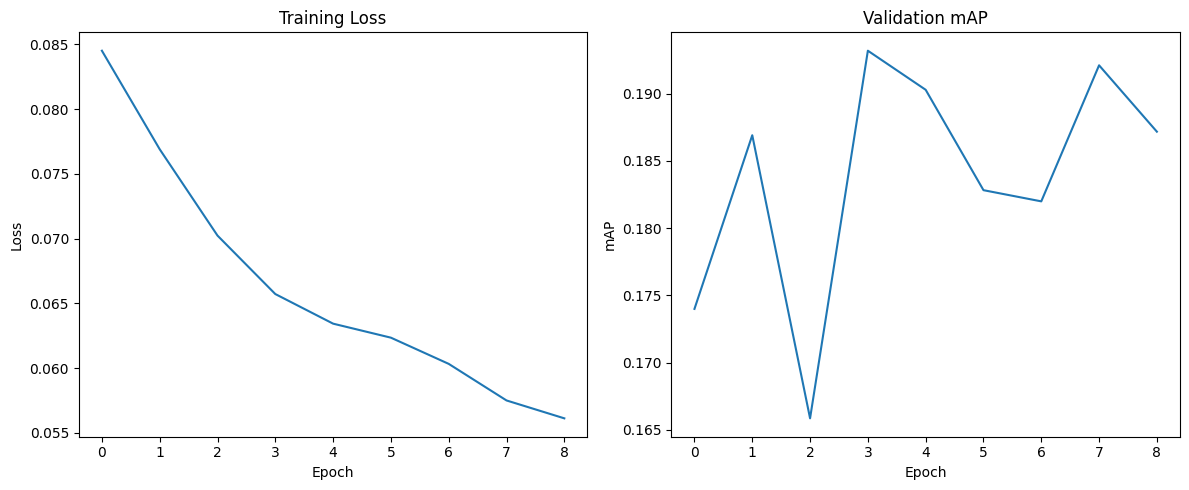

In [ ]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(val_maps)
plt.title('Validation mAP')
plt.xlabel('Epoch')
plt.ylabel('mAP')

plt.tight_layout()
plt.savefig('training_history.png')

# Final evaluation on test set
print("\nTest Set Evaluation:")
test_map = evaluate(model, test_loader, device)
print(f"Final Test mAP: {test_map:.4f}")

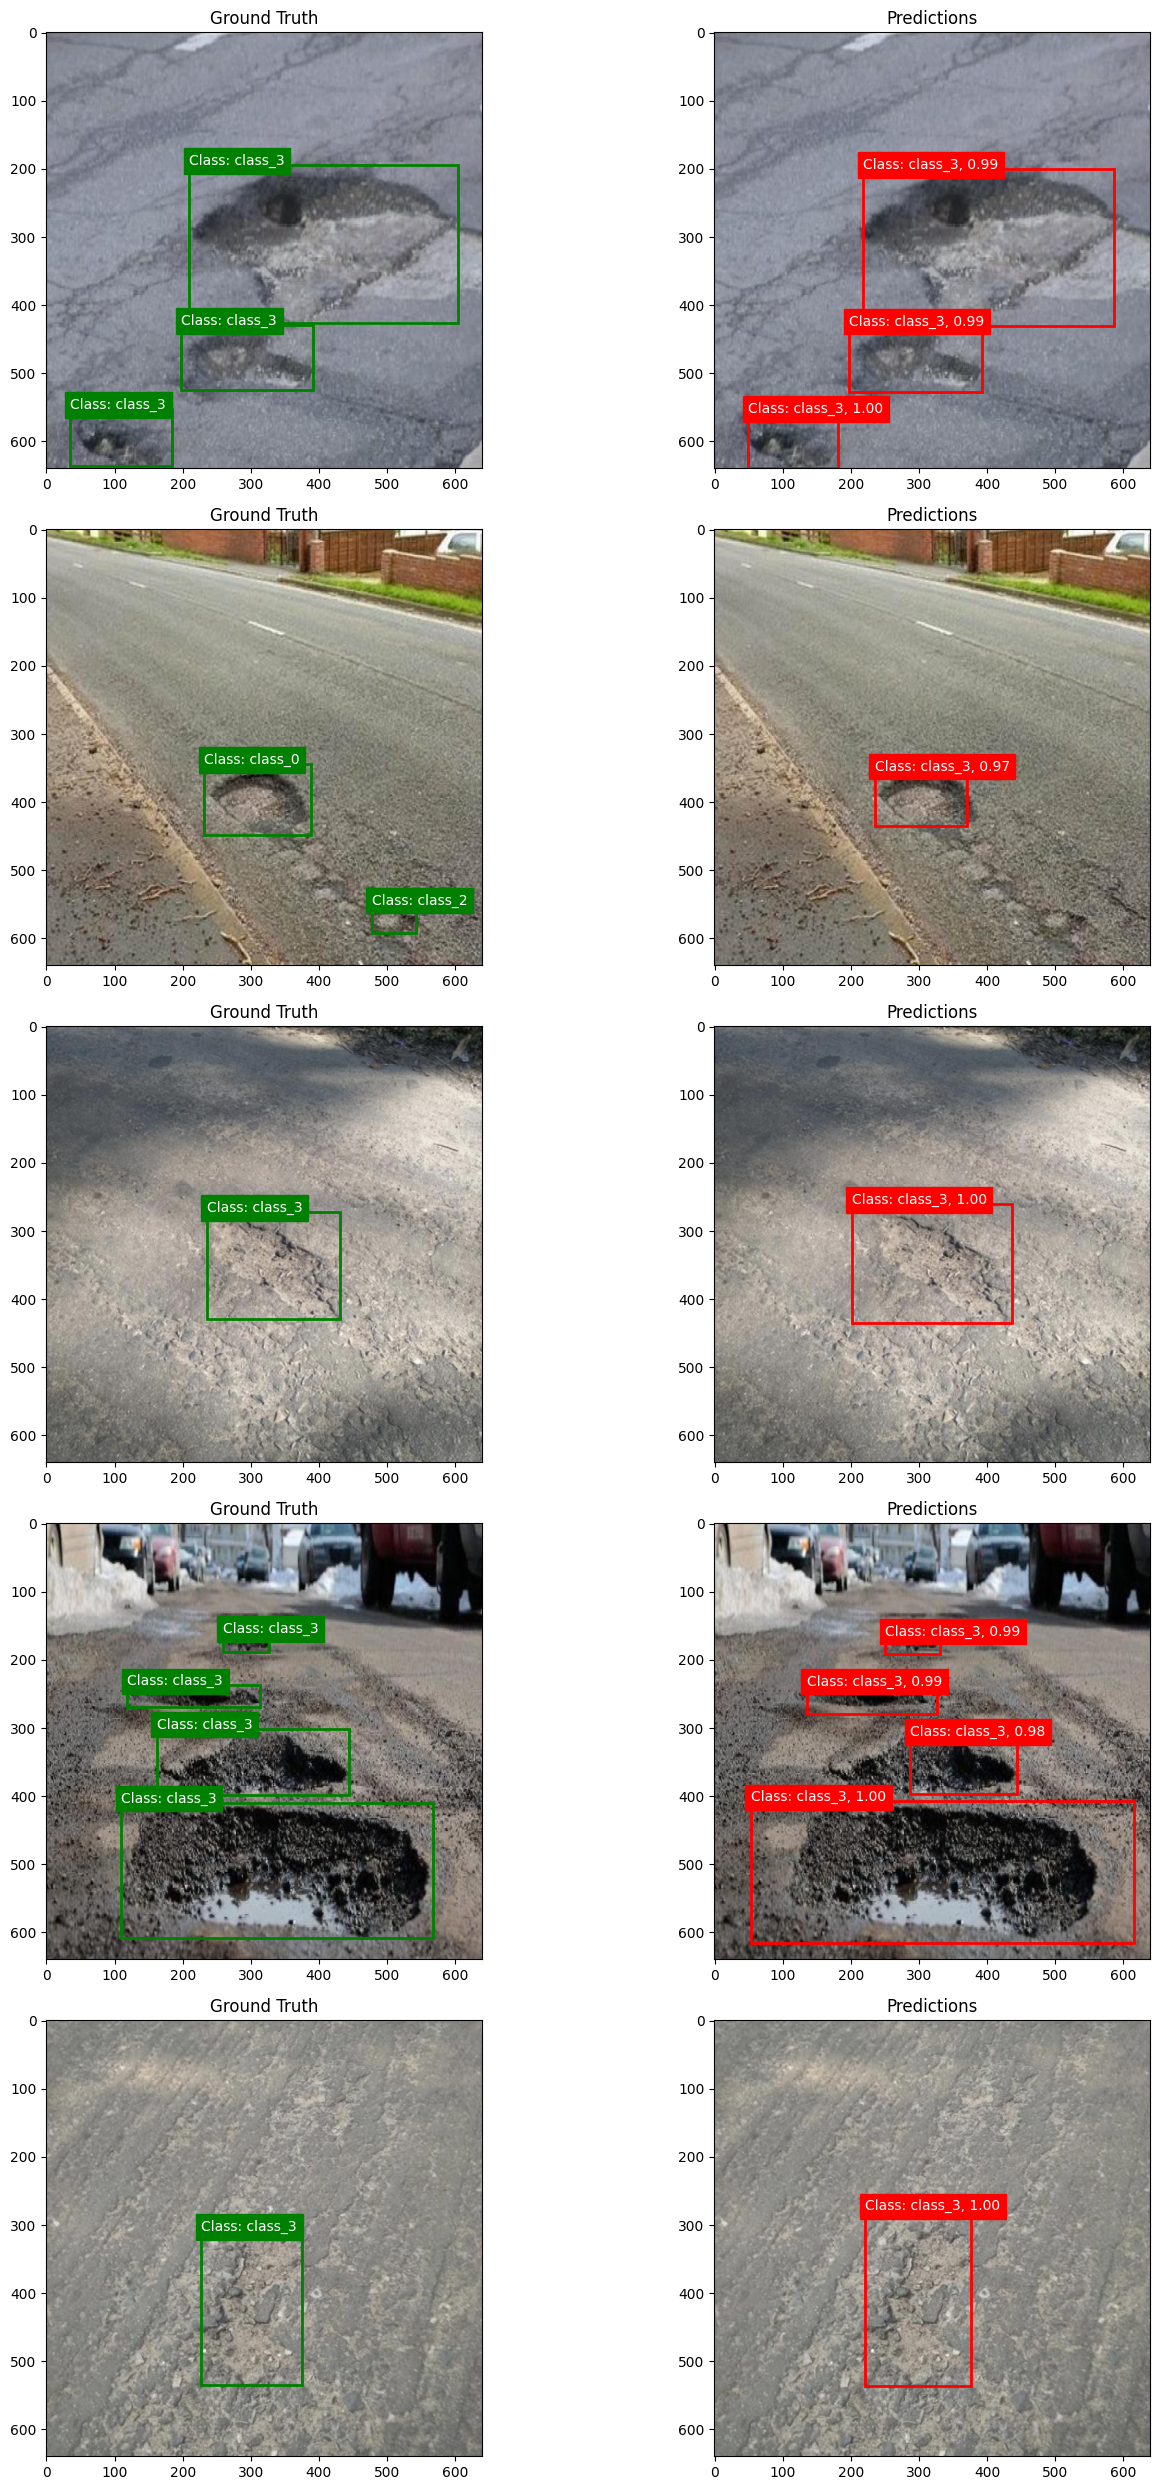

In [ ]:
# Visualize predictions on test set
visualize_predictions(model, test_dataset, device, num_images=5)

## Inference

In [ ]:
def detect_potholes(model, dataset, device, num_images=5, confidence_threshold=0.5):
    """
    Visualize model predictions on random images from the dataset
    """

    LOW_THRESHOLD = 10000
    MEDIUM_THRESHOLD = 40000

    model.eval()
    plt.figure(figsize=(15, num_images * 5))

    for i in range(num_images):
        # Get random image
        idx = np.random.randint(0, len(dataset))
        img, target = dataset[idx]

        # Get prediction
        with torch.no_grad():
            prediction = model([img.to(device)])[0]

        # Convert image for display
        img = img.permute(1, 2, 0).cpu().numpy()

        # Plot original image with ground truth
        plt.subplot(num_images, 2, 2*i + 1)
        plt.imshow(img)
        plt.title("Ground Truth")

        # Draw ground truth boxes
        for box, label in zip(target['boxes'], target['labels']):
            x1, y1, x2, y2 = box
            plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                             fill=False, color='green', linewidth=2))

            # Check if label is within bounds of category IDs
            category_ids = dataset.coco.getCatIds()
            label_item = label.item()
            if 0 <= label_item - 1 < len(category_ids):  # Subtract 1 to adjust for 0-based indexing if necessary
                category_name = dataset.coco.cats[category_ids[label_item - 1]]['name']  # Use label_item - 1
                plt.text(x1, y1, f"Class: {category_name}", color='white', backgroundcolor='green')
            else:
                print(f"Warning: Label {label_item} out of range for category IDs. Skipping this detection.")

        # Plot image with predictions
        plt.subplot(num_images, 2, 2*i + 2)
        plt.imshow(img)
        plt.title("Predictions")

        # Filter predictions by confidence threshold
        keep = prediction['scores'] > confidence_threshold
        boxes = prediction['boxes'][keep].cpu().numpy()
        labels = prediction['labels'][keep].cpu().numpy()
        scores = prediction['scores'][keep].cpu().numpy()

        # Draw predicted boxes
        for box, label, score in zip(boxes, labels, scores):
            x1, y1, x2, y2 = box
            plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                             fill=False, color='red', linewidth=2))
            # Check if label is within bounds of category IDs
            category_ids = dataset.coco.getCatIds()
            if 0 <= label - 1 < len(category_ids):  # Subtract 1 to adjust for 0-based indexing if necessary
                category_name = dataset.coco.cats[category_ids[label - 1]]['name']  # Use label - 1

                #bbox1 = BBox2D( x1, y1, x2, y2)
                bbox1 = BoundingBox.from_xyxy(np.array([x1,y1]), np.array([x2,y2]))
                area = bbox1.height * bbox1.width

                sev_level = 'unknown'
                if area <= LOW_THRESHOLD:
                  sev_level = 'low'
                elif area <= MEDIUM_THRESHOLD:
                  sev_level = 'medium'
                elif area > MEDIUM_THRESHOLD:
                  sev_level = 'high'

                plt.text(x1, y1, f"Severity: {sev_level}, Area: {area:.2f}", color='white', backgroundcolor='red')
            else:
                print(f"Warning: Label {label} out of range for category IDs. Skipping this detection.")

    plt.tight_layout()
    plt.savefig('test_predictions.png')
    plt.show()

In [ ]:
# Load a pre-trained ResNet50 backbone
backbone = torchvision.models.resnet50(pretrained=True)
# Remove the fully connected layer and average pooling layer
backbone = torch.nn.Sequential(*list(backbone.children())[:-2])
backbone.out_channels = 2048  # ResNet50 has 2048 output channels for the last convolutional layer

# Anchor generator and ROI pooling
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),))
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)

# Faster R-CNN model with ResNet50 backbone
fine_tuned_model = FasterRCNN(backbone, num_classes=num_classes, rpn_anchor_generator=anchor_generator, box_roi_pool=roi_pooler)
fine_tuned_model.load_state_dict(torch.load(BEST_MODEL_PATH, weights_only=True))
fine_tuned_model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (

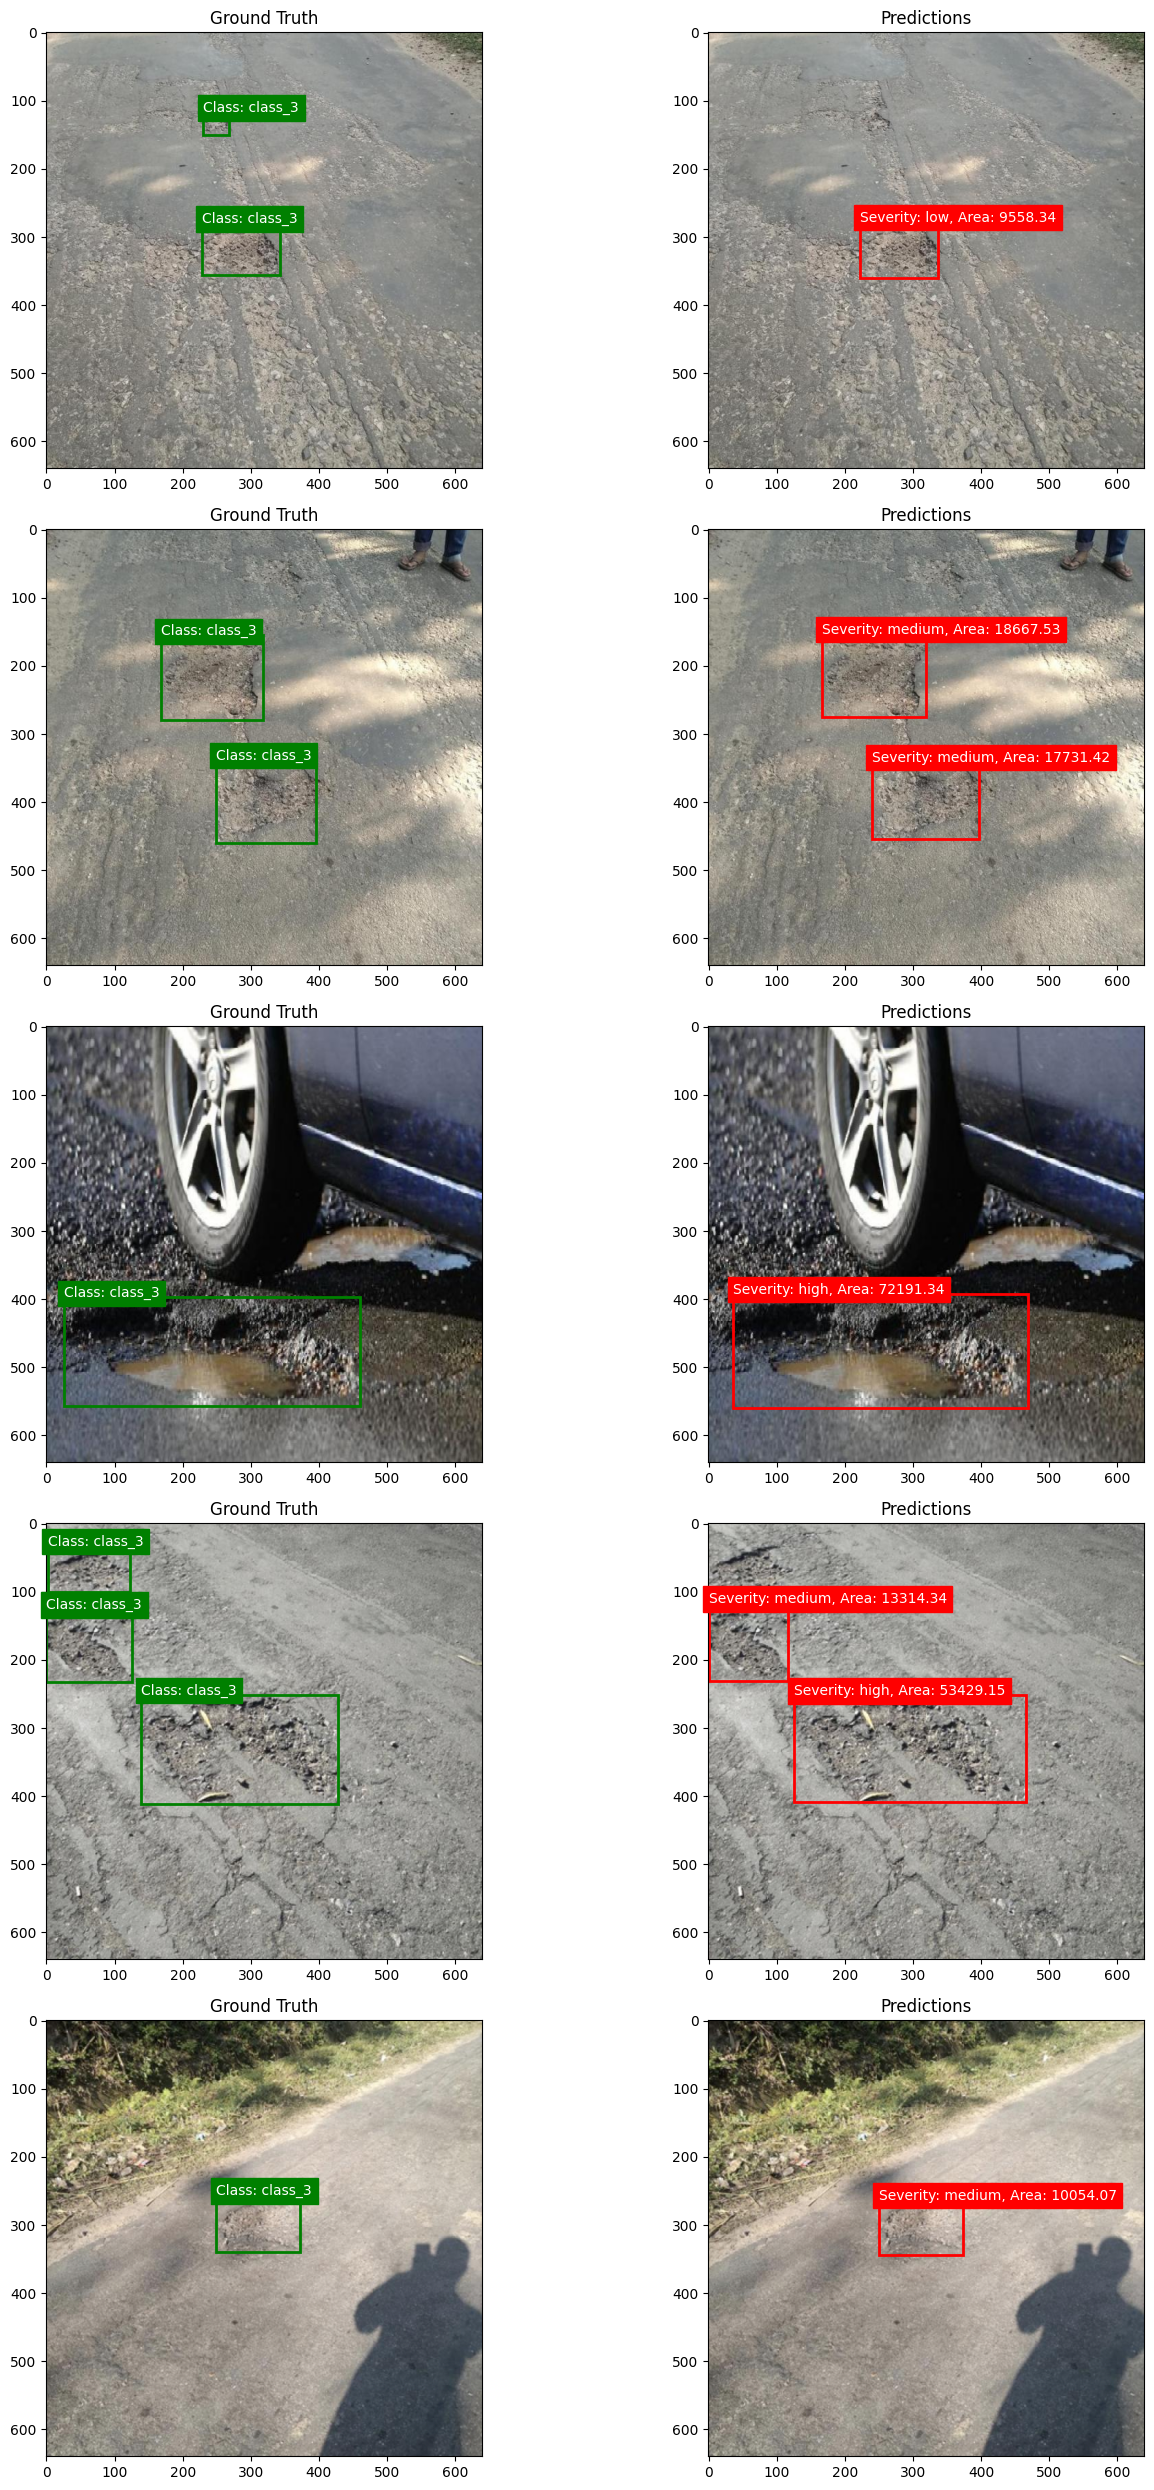

In [ ]:
detect_potholes(fine_tuned_model,test_dataset, device, num_images=5)